In [1]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from scipy.spatial.transform import Rotation as R


In [2]:
!pwd

/src/drone_causality/gazebo_environment


In [4]:
def plot_mse(df_lst, files):
    for i, df in enumerate(df_lst):
        fig, ax = plt.subplots(figsize=(8, 6))

        ax.plot(df["timestamp"], df["MSE"])
        ax.set_title(f"{files[i]}")
        ax.set_ylabel("MSE")
        ax.set_xlabel("Timestamp")
        ax.grid(True)

        # Show the plot
        plt.tight_layout()
        plt.show()


In [5]:
def extract_goal_z(filename):
    base_name = os.path.basename(filename)  # Get only the file name
    parts = base_name.split("goal")  # Split at 'goal'
    
    if len(parts) > 1:
        try:
            return float(parts[1].split(".")[0])  # Extract the numeric value
        except ValueError:
            return None  # Return None if extraction fails
    return None

# def plot_position(df_pos, files):
#     for i, df in enumerate(df_pos):
#         fig = plt.figure(figsize=(8, 6))
#         ax = fig.add_subplot(111, projection='3d')

#         # Plot in 3D space
#         ax.plot(df["x"], df["y"], df["z"])

#         # Extract Z height from filename
#         goal_z = extract_goal_z(files[i])
#         if goal_z is not None:
#             print(f"Goal Z for {files[i]}: {goal_z}")
#             ax.scatter(0.4, 0, goal_z, color='red', marker='x', s=100, label="Target Marker")

#         # Labels and title
#         ax.set_xlabel("X Position")
#         ax.set_ylabel("Y Position")
#         ax.set_zlabel("Z Position")
#         ax.set_title(f"3D Position Plot - {files[i]}")
        
#         # Legend for marker
#         ax.legend()

#         # Show the plot
#         plt.show()


In [6]:
def plot_position(df_pos, files):
    all_x, all_y, all_z = [], [], []
    
    # Collect all data points to determine global axis limits
    for df in df_pos:
        all_x.extend(df["x"])
        all_y.extend(df["y"])
        all_z.extend(df["z"])

    # Define global limits
    x_min, x_max = min(all_x), max(max(all_x),1.5)
    y_min, y_max = min(all_y), max(max(all_y),1.5)
    z_min, z_max = min(all_z), max(all_z)

    for i, df in enumerate(df_pos):
        fig = plt.figure(figsize=(10, 12))
        ax = fig.add_subplot(111, projection='3d')

        # Plot in 3D space
        ax.plot(df["x"], df["y"], df["z"], label="UAV Trajectory")

        # Extract Z height from filename
        goal_z = extract_goal_z(files[i])
        base_name = os.path.basename(files[i])[:-4]
        # print(f"Base name: {base_name}")
        if goal_z is not None:
            # print(f"Goal Z for {files[i]}: {goal_z}")
            ax.scatter(0.4, 0, goal_z, color='red', marker='x', s=100, label="Goal")

        # Set uniform axes limits
        ax.set_xlim(x_min, x_max)
        ax.set_ylim(y_min, y_max)
        ax.set_zlim(0, z_max)

        # Labels and title
        ax.set_xlabel("X")
        ax.set_ylabel("Y")
        ax.set_zlabel("Z")
        # ax.set_title(f"3D Position Plot - {files[i]}")
        # Adjust viewpoint for better visibility
        ax.view_init(elev=25, azim=135)
        # Legend for marker
        ax.legend()

        # Show the plot
        plt.show()
        
        # plt.savefig(f"new_plots_with_orientation/{base_name}.png")
        plt.close()


In [7]:
def quaternion_to_euler(df):
    quats = df[['quat_x', 'quat_y', 'quat_z', 'quat_w']].values
    r = R.from_quat(quats)
    euler_angles = r.as_euler('xyz', degrees=True)
    df['euler_x'] = euler_angles[:, 0]
    df['euler_y'] = euler_angles[:, 1]
    df['euler_z'] = euler_angles[:, 2]
    return df


In [8]:
def plot_pose_error(df_pos, files):
    goal_x, goal_y = 0.4, 0  # Fixed goal positions

    # Determine global min and max for axis limits
    all_errors_x, all_errors_y, all_errors_z, all_abs_errors, all_euler_z = [], [], [], [], []

    for i, df in enumerate(df_pos):
        goal_z = extract_goal_z(files[i])  # Extract goal Z from filename
        print(files[i], goal_z)
        if goal_z is not None:
            errors_x = df["x"] - goal_x
            errors_y = df["y"] - goal_y
            errors_z = df["z"] - goal_z
            abs_error = np.sqrt(errors_x**2 + errors_y**2 + errors_z**2)  # Absolute position error
            
            # euler_z = quaternion_to_euler(df["quat_w"].values, df["quat_x"].values, df["quat_y"].values, df["quat_z"].values)
            euler_z = df["euler_z"]
            
            all_errors_x.extend(errors_x)
            all_errors_y.extend(errors_y)
            all_errors_z.extend(errors_z)
            all_abs_errors.extend(abs_error)
            all_euler_z.extend(euler_z)
    
    # Get the min and max for uniform axis limits
    min_error = min(min(all_errors_x), min(all_errors_y), min(all_errors_z), min(all_abs_errors), -1.5)
    max_error = max(max(all_errors_x), max(all_errors_y), max(all_errors_z), max(all_abs_errors), 3.5)
    min_euler_z, max_euler_z = min(all_euler_z), max(all_euler_z)

    for i, df in enumerate(df_pos):
        goal_z = extract_goal_z(files[i])  # Extract goal Z from filename
        base_name = os.path.basename(files[i])[:-4]
        
        if goal_z is not None:
            print(f"Plotting for {files[i]}")
            errors_x = df["x"] - goal_x
            errors_y = df["y"] - goal_y
            errors_z = df["z"] - goal_z
            # df["euler_z"] = np.arctan2(np.sin(df["euler_z"]), np.cos(df["euler_z"]))  # Normalize to [-π, π]
            # df["euler_z"] /= np.pi
            
            df["euler_z"] = np.mod(df["euler_z"] + 180, 360) - 180  # Normalize to [-180, 180]
            df["euler_z"] = 1 - np.abs(df["euler_z"] / 180)  
            euler_z = df["euler_z"]

            timestamp_min, timestamp_max = df["timestamp"].min(), df["timestamp"].max()
            time_range = (timestamp_max - timestamp_min) / 20  # Scale to desired range
            time = np.linspace(0, time_range, len(df["timestamp"]))

            # print(len(euler))
            # euler_z = (euler_z - 180)
            print(f"Position Errors for File: {files[i]}")
            plt.figure(figsize=(8, 5))
            plt.plot(time, errors_x, label=r'$p_{e_{x}}$')
            plt.plot(time, errors_y, label=r'$p_{e_{y}}$')
            plt.plot(time, errors_z, label=r'$p_{e_{z}}$')
            plt.plot(time, euler_z, label=r'$p_{e_{\omega}}$')
            plt.xlabel("Time (sec)")
            plt.ylabel("Pose Error")
            # plt.title(f"Position Errors for File: {files[i]}")
            plt.ylim(min_error, max_error)  # Set same limits for all graphs
            plt.legend()
            plt.grid(True)
            # plt.savefig(f"new_plots_with_orientation/pos_error_{base_name}.png")
            plt.show()
            plt.close()

            # plt.figure(figsize=(8, 5))
            # plt.plot(euler_z, label="Euler Z (Yaw) Angle")
            # plt.xlabel("Timestep")
            # plt.ylabel("Angle (Degrees)")
            # plt.title(f"Euler Z Angle for File: {files[i]}")
            # # plt.ylim(min_euler_z, max_euler_z)
            # plt.legend()
            # plt.grid(True)
            # plt.show()
            # # plt.savefig(f"position_error/{base_name}_yaw.png")
            # plt.close()


In [9]:
def plot_feature_errors(file_paths):
    # Process each file separately and plot them in individual graphs
    for i, file_path in enumerate(file_paths):
        # Load CSV file
        df = pd.read_csv(file_path, dtype=str)
        base_name = os.path.basename(file_path)[:-4]
        # Parse e_v_x, e_v_y, and e_v_a as numerical lists
        df["e_v_x"] = df["e_v_x"].apply(lambda x: np.fromstring(x.strip("[]"), sep=" "))
        df["e_v_y"] = df["e_v_y"].apply(lambda x: np.fromstring(x.strip("[]"), sep=" "))
        df["e_v_a"] = df["e_v_a"].apply(lambda x: np.fromstring(x.strip("[]"), sep=" "))

        # Extract diagonal components
        df["e_v_x_diag"] = df["e_v_x"].apply(lambda x: x[0])
        df["e_v_y_diag"] = df["e_v_y"].apply(lambda x: x[1])
        df["e_v_a_diag"] = df["e_v_a"].apply(lambda x: x[2])

        # Extract e_alpha as a float
        df["e_alpha"] = df["e_alpha"].apply(lambda x: float(x.strip("[]")))

        # Convert timestamp to float
        df["timestamp"] = df["timestamp"].astype(float)
        df["e_alpha"] = (df["e_alpha"] + np.pi) % (2 * np.pi) - np.pi

        # Extract time
        timestamp_min, timestamp_max = df["timestamp"].min(), df["timestamp"].max()
        time_range = (timestamp_max - timestamp_min) / 20  # Scale to desired range
        time_lst = np.linspace(0, time_range, len(df["timestamp"]))

        # df["e_alpha"] = np.mod(df["euler_z"] + 180, 360) - 180  # Normalize to [-180, 180]
        # df["euler_z"] = 1 - np.abs(df["euler_z"] / 180)  
        df["e_alpha"] = abs(df["e_alpha"])
        
        # Plot for the current file
        print(f"Diagonal components of e_vx, e_vy, e_va along with e_alpha\nFile: {file_path.split('/')[-1]}")
        plt.figure(figsize=(8, 5))
        plt.plot(time_lst, df["e_v_x_diag"], label=r'$e_{x}$', color='blue')
        plt.plot(time_lst, df["e_v_y_diag"], label=r'$e_{y}$', color='red')
        plt.plot(time_lst, df["e_v_a_diag"], label=r'$e_{a}$', color='orange')
        plt.plot(time_lst, df["e_alpha"], label=r'$e_{\alpha}$', color='purple')

        plt.xlabel("Time (sec)")
        plt.ylabel("Feature Error")
        # plt.title(f"Diagonal components of e_vx, e_vy, e_va along with e_alpha\nFile: {file_path.split('/')[-1]}")
        plt.legend()
        plt.grid(True)

        # Display the plot
        plt.show()
        # plt.savefig(f"new_plots_with_orientation/feature_error_{base_name}.png")
        plt.close()


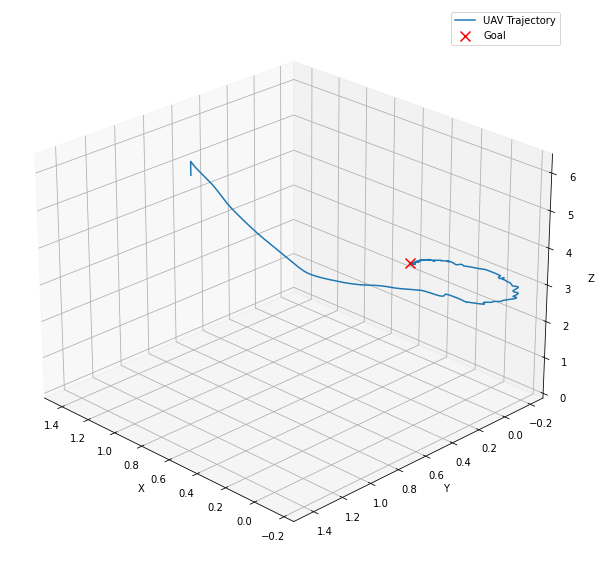

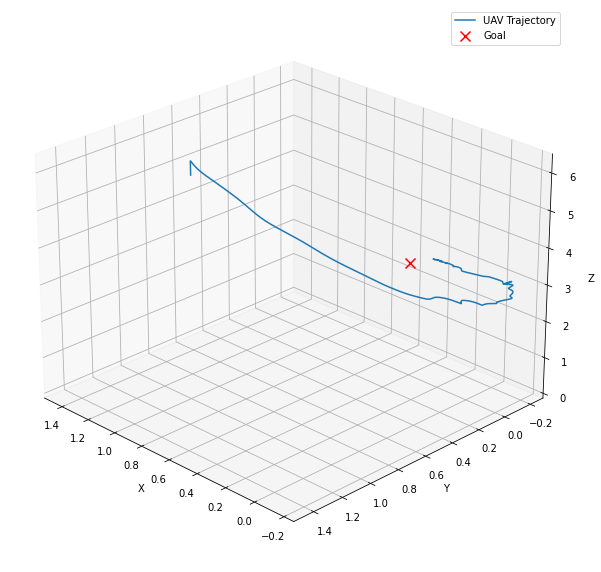

In [9]:
root = './different_background_marker/new_results_with_orientation'
files = [os.path.join(root,f) for f in os.listdir(root) if "result" in f]
file_paths = [os.path.join(root,f) for f in os.listdir(root) if "ibvs" in f]

# pos_root = './marker/position_results'
# pos_files = [os.path.join(pos_root,f) for f in os.listdir(pos_root)]

df_lst = [pd.read_csv(f) for f in files]
df_with_euler = [quaternion_to_euler(df) for df in df_lst]
# df_with_euler[0].head()
# plot_pose_error(df_with_euler, files)
# plot_feature_errors(file_paths)
plot_position(df_with_euler, files)

In [48]:
root = './marker/new_results_with_orientation'
files = [os.path.join(root,f) for f in os.listdir(root) if "new_result" in f]
file_paths = [os.path.join(root,f) for f in os.listdir(root) if "ibvs" in f]

# pos_root = './marker/position_results'
# pos_files = [os.path.join(pos_root,f) for f in os.listdir(pos_root)]

df_lst = [pd.read_csv(f) for f in files]
df_with_euler = [quaternion_to_euler(df) for df in df_lst]
# df_with_euler[0].head()
# plot_pose_error(df_with_euler, files)

# df_pos = [pd.read_csv(f) for f in pos_files]

# plot_feature_errors(file_paths)
plot_position(df_with_euler, files)
# # plot_mse(df_lst, files)
# plot_pos_error(df_pos, pos_files)

In [49]:
root_markerless = './markerless/new_results_with_orientation'
files_markerless = [os.path.join(root_markerless,f) for f in os.listdir(root_markerless)]

# pos_root_markerless = './markerless/position_results'
# pos_files_markerless = [os.path.join(pos_root_markerless,f) for f in os.listdir(pos_root_markerless)]

df_lst_markerless = [pd.read_csv(f) for f in files_markerless]
df_with_euler_markerless = [quaternion_to_euler(df) for df in df_lst_markerless]
# print(df_with_euler_markerless[0].head())
# df_pos_markerless = [pd.read_csv(f) for f in pos_files_markerless]

plot_position(df_lst_markerless, files_markerless)
# plot_mse(df_lst_markerless, mse_files_markerless)
plot_pose_error(df_with_euler_markerless, files_markerless)



In [86]:
# # Define function to plot moving trajectories for all dataframes
# def plot_moving(df_lst, files_marker_moving):
#     for i, df in enumerate(df_lst):
#         # Find the first index where x < 4.5
#         first_x_below_4_5_index = df[df["z"] < 4.5].index.min()

#         # Slice the dataframe from that index onwards for x and y
#         filtered_xy_df = df.loc[first_x_below_4_5_index:, ["x", "y", "z"]]

#         # Extract Husky x, y, z coordinates as they are
#         husky_x = df["Husky_x"]
#         husky_y = df["Husky_y"]
#         husky_z = df["Husky_z"]

#         # Create 3D plot
#         fig = plt.figure(figsize=(10, 7))
#         ax = fig.add_subplot(111, projection='3d')

#         # Plot Husky trajectory
#         ax.scatter(husky_x, husky_y, husky_z, c='b', marker='^', label="Husky Path")

#         # Plot filtered x and y (assuming z=0 for visibility in 3D space)
#         ax.scatter(filtered_xy_df["x"], filtered_xy_df["y"], filtered_xy_df["z"], c='r', marker='o', label="Filtered Marker Path (x, y)")

#         # Labels and title
#         ax.set_xlabel("X-axis")
#         ax.set_ylabel("Y-axis")
#         ax.set_zlabel("Z-axis")
#         ax.set_title(f"3D Plot of Husky and Filtered Marker Trajectory ({os.path.basename(files_marker_moving[i])})")
#         ax.legend()

#         # Show plot
#         plt.show()



In [88]:
# import open3d as o3d
# import numpy as np
# import os

# def plot_moving_open3d(df_lst, files_marker_moving):
#     """
#     Plots the Husky path and the filtered marker path for each DataFrame in df_lst
#     using Open3D's interactive 3D viewer.
#     """
#     all_geometries = []

#     for i, df in enumerate(df_lst):
#         # ----------------------------------------------------
#         # 1) Filter your data as before
#         # ----------------------------------------------------
#         # Find the first index where x < 4.5
#         first_x_below_4_5_index = df[df["x"] < 4.5].index.min()
        
#         # Slice the dataframe from that index onwards for x and y
#         filtered_xy_df = df.loc[first_x_below_4_5_index:, ["x", "y"]]
        
#         # Extract Husky x, y, z coordinates
#         husky_x = df["Husky_x"].values
#         husky_y = df["Husky_y"].values
#         husky_z = df["Husky_z"].values

#         # ----------------------------------------------------
#         # 2) Create NumPy arrays for Open3D point clouds
#         # ----------------------------------------------------
#         # Husky path points
#         husky_points = np.column_stack((husky_x, husky_y, husky_z))
        
#         # Marker path points (z=0 to visualize on the "ground" plane)
#         marker_points = np.column_stack((
#             filtered_xy_df["x"].values,
#             filtered_xy_df["y"].values,
#             np.zeros_like(filtered_xy_df["x"].values)
#         ))

#         # ----------------------------------------------------
#         # 3) Convert arrays to Open3D PointCloud objects
#         # ----------------------------------------------------
#         husky_pc = o3d.geometry.PointCloud()
#         husky_pc.points = o3d.utility.Vector3dVector(husky_points)
        
#         marker_pc = o3d.geometry.PointCloud()
#         marker_pc.points = o3d.utility.Vector3dVector(marker_points)

#         # ----------------------------------------------------
#         # 4) Color the point clouds for clarity
#         # ----------------------------------------------------
#         # Husky path in blue
#         husky_pc.paint_uniform_color([0.0, 0.0, 1.0])
#         # Marker path in red
#         marker_pc.paint_uniform_color([1.0, 0.0, 0.0])

#         # ----------------------------------------------------
#         # 5) Collect the geometries for this DataFrame
#         # ----------------------------------------------------
#         all_geometries.append(husky_pc)
#         all_geometries.append(marker_pc)

#     # ----------------------------------------------------
#     # 6) Visualize everything together in one window
#     # ----------------------------------------------------
#     o3d.visualization.draw_geometries(all_geometries)


In [10]:
import os
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

def plot_moving(df_lst, files_marker_moving):
    for i, df in enumerate(df_lst):
        # Find the first index where z < 4.5
        # goal_z = extract_goal_z(files_marker_moving[i])
        first_z_below_4_5_index = df[df["z"] < 4.5 ].index.min()

        # Slice the dataframe from that index onwards for x, y, and z
        filtered_xyz_df = df.loc[first_z_below_4_5_index:]

        # Extract Husky x, y, z coordinates
        husky_x = filtered_xyz_df["Husky_x"]
        husky_y = filtered_xyz_df["Husky_y"]
        husky_z = filtered_xyz_df["Husky_z"]

        # Create 3D plot with a larger figure size
        fig = plt.figure(figsize=(12, 9))
        ax = fig.add_subplot(111, projection='3d')

        # Plot Husky trajectory (blue line with markers)
        ax.plot(husky_x, husky_y, husky_z, c='b', marker='^', linestyle='-', linewidth=2, markersize=6, label="Husky Path")

        # Plot filtered marker trajectory (red with increased marker size and transparency)
        ax.scatter(filtered_xyz_df["x"], filtered_xyz_df["y"], filtered_xyz_df["z"],
                    c='r', marker='o', s=30, alpha=0.8, label="Filtered Marker Path")
        ax.scatter(husky_x.iloc[0], husky_y.iloc[0], husky_z.iloc[0], c='g', marker='s', s=100, label="Husky Start")
        ax.scatter(husky_x.iloc[-1], husky_y.iloc[-1], husky_z.iloc[-1], c='k', marker='X', s=100, label="Husky End")

        ax.scatter(filtered_xyz_df["x"].iloc[0], filtered_xyz_df["y"].iloc[0], filtered_xyz_df["z"].iloc[0],
                c='m', marker='D', s=100, label="Quadrotor Start")
        ax.scatter(filtered_xyz_df["x"].iloc[-1], filtered_xyz_df["y"].iloc[-1], filtered_xyz_df["z"].iloc[-1],
                c='c', marker='P', s=100, label="Quadrotor End")
        
        ax.scatter(husky_x, husky_y, filtered_xyz_df["z"], c='g', label="Husky ")
        

        # Improve visibility with grid and labels
        ax.set_xlabel("X-axis", fontsize=12, labelpad=10)
        ax.set_ylabel("Y-axis", fontsize=12, labelpad=10)
        ax.set_zlabel("Z-axis", fontsize=12, labelpad=10)
        ax.set_title(f"3D Plot of Husky and Filtered Marker Trajectory ({os.path.basename(files_marker_moving[i])})",
                     fontsize=14, pad=15)
        # ax.legend(fontsize=12, loc='best')
        
        # Add a grid for better depth perception
        ax.grid(True, linestyle='--', linewidth=0.5)
        
        # Adjust viewpoint for better visibility
        ax.view_init(elev=25, azim=135)
        
        # Show plot
        plt.show()

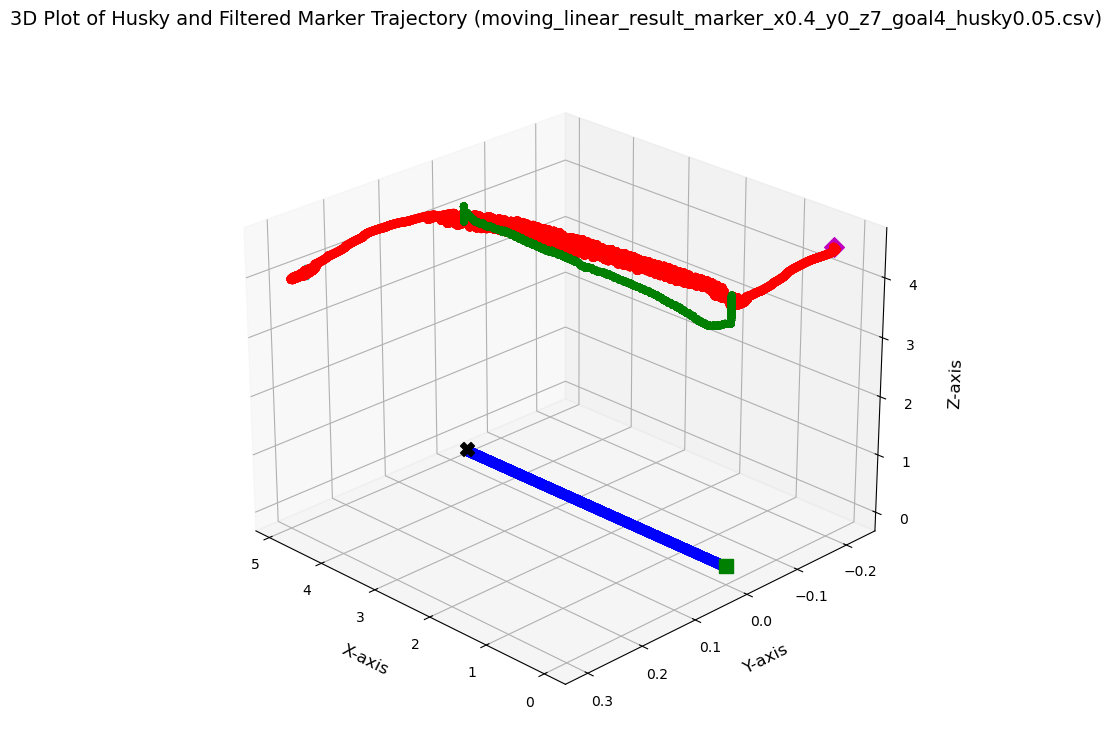

In [37]:
root_marker_moving = './moving_target_marker/new_results_with_orientation'
files_marker_moving = [os.path.join(root_marker_moving,f) for f in os.listdir(root_marker_moving) if "moving_linear_result_marker_x0.4_y0_z7_goal4_husky0.05.csv" in f]
file_paths = [os.path.join(root_marker_moving,f) for f in os.listdir(root_marker_moving) if "ibvs" in f]

df_lst = [pd.read_csv(f) for f in files_marker_moving]
# df_with_euler = [quaternion_to_euler(df) for df in df_lst]
# plot_pose_error(df_with_euler, files)
# plot_feature_errors(file_paths)
# plot_position(df_with_euler, files)
plot_moving(df_lst, files_marker_moving)


In [22]:
root_marker_moving = './moving_target_markerless/new_results_with_orientation'
files_marker_moving = [os.path.join(root_marker_moving,f) for f in os.listdir(root_marker_moving) if "moving_linear_result_markerless" in f]
file_paths = [os.path.join(root_marker_moving,f) for f in os.listdir(root_marker_moving) ]

# df_lst = [pd.read_csv(f) for f in files_marker_moving]
# df_with_euler = [quaternion_to_euler(df) for df in df_lst]
# plot_pose_error(df_with_euler, files_marker_moving)
# plot_feature_errors(file_paths)
# # plot_position(df_with_euler, files)
# plot_moving(df_lst, files_marker_moving)

In [23]:
file_paths

['./moving_target_markerless/new_results_with_orientation/moving_linear_result_markerless_x0.4_y0_z6_goal3_husky0.2.csv',
 './moving_target_markerless/new_results_with_orientation/moving_linear_result_markerless_x0.4_y0_z7_goal4_husky0.2.csv',
 './moving_target_markerless/new_results_with_orientation/moving_result_markerless_x0.4_y0_z6_goal3.csv',
 './moving_target_markerless/new_results_with_orientation/moving_result_markerless_x0.4_y0_z7_goal4.csv',
 './moving_target_markerless/new_results_with_orientation/moving_linear_result_markerless_x0.4_y0_z6_goal3_husky0.05.csv']

In [18]:
files_marker_moving

['./moving_target_marker/new_results_with_orientation/moving_result_marker_x0.4_y0_z6_goal3.csv',
 './moving_target_marker/new_results_with_orientation/moving_ibvs_feature_error_marker_x0.4_y0_z6_goal3.csv']